# Prometne nesreče v Sloveniji #

## Uvod
Za seminarsko nalogo bom analiziral podatke o prometnih nesrečah v Sloveniji za leti 2019 in 2020. Podatke sem pridobil
iz spletne strani policija.si (https://www.policija.si/o-slovenski-policiji/statistika/prometna-varnost). Isti podatki so tudi dostopni
na spletni strani podatki.gov.si (https://podatki.gov.si/dataset/mnzpprometne-nesrece-od-leta-2009-dalje), vendar manjkajo podatki za leto 2020.


## Cilji
  * Analiza in vizualizacija podatkov.
  * Odgovoriti na vnaprej postavljena vprašanja in na morebitna vprašanja, ki se pojavijo ob reševanju problema.
  * Napovedovanje vrednosti alkohola v krvi na podlagi okoliščin nesreče.
  
  
  ### Vprašanja
  * Kateri vozniki povzročajo največ nesreč?
  * Kakšne okoliščine povzročajo največ nesreč?
  * Ali količina alkohola v krvi voznika, vpliva na težavnost poškodbe?
  

## Branje podatkov ##

In [22]:
#knjužnice

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta, date

In [2]:
data20 = pd.read_csv("Data/pn2020.csv", ";", encoding="cp1252", decimal=",")
data19 = pd.read_csv("Data/pn2019.csv", ";", encoding="cp1252", decimal=",")

## Priprava podatkov ##

Vse vrsice z mankajočimi vrednostmi odstranimo iz podatkov.

In [3]:
data20 = data20.dropna()
data19 = data19.dropna()

Združimo polji vrednost alkotesta in vrednost strokovnega pregleda. Enote je potrebno vskladiti

In [4]:
# 4 nivoji
alc = []
for a, b in zip(data20["VrednostAlkotesta"], data20["VrednostStrokovnegaPregleda"]):
    if a > 0.8 or b > 0.38:
        alc.append(3)
        continue
    elif ((a <= 0.8 and a > 0.5) or (b <= 0.38 and  b > 0.24)):
        alc.append(2)
        continue
    elif ((a <= 0.5 and a > 0.3) or (b <= 0.24 and  b > 0.14)):
        alc.append(1)
        continue
    else:
        alc.append(0)
data20["stopnjaAlkohola"] = alc

alc = []
for a, b in zip(data19["VrednostAlkotesta"], data19["VrednostStrokovnegaPregleda"]):
    if a > 0.8 or b > 0.38:
        alc.append(3)
        continue
    elif ((a <= 0.8 and a > 0.5) or (b <= 0.38 and  b > 0.24)):
        alc.append(2)
        continue
    elif ((a <= 0.5 and a > 0.3) or (b <= 0.24 and  b > 0.14)):
        alc.append(1)
        continue
    else:
        alc.append(0)
data19["stopnjaAlkohola"] = alc

V nadaljevanju bomo obe mnoožici obdelovali kot eno.

In [11]:
data = pd.concat([data19,data20])

Spremenimo tip datuma v datetime.

In [35]:
dateFormat19 = np.array([datetime.strptime(datum,"%d.%m.%Y" ) for datum in data19["DatumPN"]])
dateFormat20 = [datetime.strptime(datum,"%d.%m.%Y" ) for datum in data20["DatumPN"]]

In [45]:
start_date = datetime(2019, 1, 1)
end_date = datetime(2019, 12, 31)
delta = timedelta(days=1)
velikosti = []

while start_date <= end_date:
    velikosti.append(len(dateFormat19[dateFormat19 == start_date]))
    start_date += delta

(array([17., 35., 45., 74., 73., 66., 36., 11.,  5.,  3.]),
 array([ 22. ,  36.2,  50.4,  64.6,  78.8,  93. , 107.2, 121.4, 135.6,
        149.8, 164. ]),
 <BarContainer object of 10 artists>)

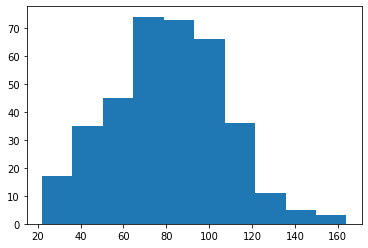

In [46]:
plt.hist(velikosti)

In [ ]:
start_date.strftime("%d.%m.%Y")

## Analiza ##

In [7]:
#plt.hist(data20["DatumPN"])

In [6]:
data19["DatumPN"][0]

'08.01.2019'

In [7]:
#datetime.strptime(data19["DatumPN"][0], "%d.%m.%Y")

In [8]:
#plt.plot(data19["DatumPN"])